In [2]:
import pandas as pd

In [4]:
transformed = pd.read_csv('transformed.csv')

In [24]:
from sklearn import preprocessing
import tensorflow
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
transformed[LABEL] = le.fit_transform(transformed['activity'].values.ravel())
y  = transformed[LABEL]

x_trains = transformed.drop(columns=['activity',LABEL],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_trains,y, train_size=0.8, random_state=42)

y_train_hot = tensorflow.keras.utils.to_categorical(y_train, 6)

New y_train shape:  (8127, 6)


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)

all_X = scaler.transform(x_trains)
all_y_hot = tensorflow.keras.utils.to_categorical(y, 6)

In [31]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
model_m = Sequential()
num_classes = 6
input_shape = all_X.shape
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
model_m.build(input_shape)
print(model_m.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (8127, 100)               11300     
                                                                 
 dense_21 (Dense)            (8127, 100)               10100     
                                                                 
 dense_22 (Dense)            (8127, 100)               10100     
                                                                 
 flatten_5 (Flatten)         (8127, 100)               0         
                                                                 
 dense_23 (Dense)            (8127, 6)                 606       
                                                                 
Total params: 32,106
Trainable params: 32,106
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(all_X,
                      all_y_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
17/17 [==============================] - 3s 29ms/step - loss: 1.1274 - accuracy: 0.6396 - val_loss: 0.6184 - val_accuracy: 0.8210
Epoch 2/50
17/17 [==============================] - 0s 19ms/step - loss: 0.5314 - accuracy: 0.8205 - val_loss: 0.4523 - val_accuracy: 0.8432
Epoch 3/50
17/17 [==============================] - 0s 19ms/step - loss: 0.3525 - accuracy: 0.8751 - val_loss: 0.4179 - val_accuracy: 0.8450
Epoch 4/50
17/17 [==============================] - 0s 27ms/step - loss: 0.2841 - accuracy: 0.8991 - val_loss: 0.4323 - val_accuracy: 0.8432
Epoch 5/50
17/17 [==============================] - 0s 16ms/step - loss: 0.2445 - accuracy: 0.9128 - val_loss: 0.4314 - val_accuracy: 0.8444
Epoch 6/50
17/17 [==============================] - 0s 23ms/step - loss: 0.2118 - accuracy: 0.9245 - val_loss: 0.4125 - val_accuracy: 0.8487
Epoch 7/50
17/17 [==============================] - 0s 20ms/step - loss: 0.1876 - accuracy: 0.9339 - val_loss: 0.4098 - val_accuracy: 0.8530
Epoch 8/50
17

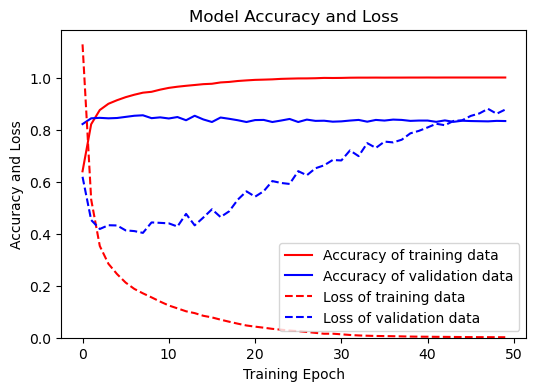

254/254 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       726
           1       0.99      0.98      0.98      2438
           2       1.00      0.99      1.00       492
           3       0.99      1.00      1.00       390
           4       0.87      0.94      0.90       813
           5       0.99      0.96      0.97      3268

    accuracy                           0.97      8127
   macro avg       0.95      0.97      0.96      8127
weighted avg       0.97      0.97      0.97      8127



In [33]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(all_X)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y, max_y_pred_train))

In [34]:
y_test_pred = model_m.predict(X_test_data_lr)
max_y_pred_train = np.argmax(y_test_pred, axis=1)
print(classification_report(y_test, max_y_pred_train))

51/51 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       143
           1       0.99      0.98      0.99       481
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00        82
           4       0.92      0.93      0.93       159
           5       0.99      0.97      0.98       645

    accuracy                           0.97      1626
   macro avg       0.96      0.97      0.97      1626
weighted avg       0.97      0.97      0.97      1626



In [38]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')
def transformation(df_train):
    x_list = []
    y_list = []
    z_list = []
    train_labels = []

    users = df_train['user_snippet'].unique()

    # creating overlaping windows of size window-size 100
    for i in range(0, len(users)):
        s_train = df_train[df_train['user_snippet'] == users[i]]
        xs = s_train['x-axis'].values
        ys = s_train['y-axis'].values
        zs = s_train['z-axis'].values
        #label = stats.mode(df_train['activity'][i: i + 100])[0][0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        #train_labels.append(label)

    # Statistical Features on raw x, y and z in time domain
    X_train = pd.DataFrame()

    # mean
    X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
    X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
    X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

    # std dev
    X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
    X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
    X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

    # avg absolute diff
    X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
    X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
    X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

    # max
    X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
    X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
    X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

    # max-min diff
    X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
    X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
    X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

    # median
    X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
    X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
    X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

    # median abs dev 
    X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negtive count
    X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
    X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
    X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

    # positive count
    X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
    X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
    X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

    # values above mean
    X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
    X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
    X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
    X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
    X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

    # skewness
    X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
    X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
    X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

    # kurtosis
    X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
    X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
    X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

    # energy
    X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
    X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
    X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

    # avg resultant
    X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

    # signal magnitude area
    X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                    + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))
    x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

    # Statistical Features on raw x, y and z in frequency domain
    # FFT mean
    X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
    X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
    X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

    # FFT std dev
    X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
    X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
    X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

    # FFT avg absolute diff
    X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # FFT min
    X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
    X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
    X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

    # FFT max
    X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
    X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
    X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

    # FFT max-min diff
    X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
    X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
    X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

    # FFT median
    X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
    X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
    X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

    # FFT median abs dev 
    X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # FFT Interquartile range
    X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # FFT values above mean
    X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
    X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
    X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

    # FFT number of peaks
    X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

    # FFT skewness
    X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
    X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
    X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

    # FFT kurtosis
    X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
    X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
    X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

    # FFT energy
    X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
    X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
    X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

    # FFT avg resultant
    X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

    # FFT Signal magnitude area
    X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                        + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))
    X_train['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
    X_train['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
    X_train['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

    # index of min value in time domain
    X_train['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
    X_train['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
    X_train['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

    # absolute difference between above indices
    X_train['x_arg_diff'] = abs(X_train['x_argmax'] - X_train['x_argmin'])
    X_train['y_arg_diff'] = abs(X_train['y_argmax'] - X_train['y_argmin'])
    X_train['z_arg_diff'] = abs(X_train['z_argmax'] - X_train['z_argmin'])

    # index of max value in frequency domain
    X_train['x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    X_train['y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    X_train['z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

    # index of min value in frequency domain
    X_train['x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    X_train['y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    X_train['z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

    # absolute difference between above indices
    X_train['x_arg_diff_fft'] = abs(X_train['x_argmax_fft'] - X_train['x_argmin_fft'])
    X_train['y_arg_diff_fft'] = abs(X_train['y_argmax_fft'] - X_train['y_argmin_fft'])
    X_train['z_arg_diff_fft'] = abs(X_train['z_argmax_fft'] - X_train['z_argmin_fft'])

    return X_train

test_df = pd.read_csv('signals_test.csv')
transformed_test = transformation(test_df)
transformed_test.to_csv('transformed_test.csv',index=False)

In [39]:
predict_x = scaler.transform(transformed_test)
predict_y = model_m.predict(predict_x)

82/82 [==============================] - 1s 8ms/step


In [40]:
max_y_pred_train = np.argmax(predict_y, axis=1)

In [41]:
prediction = le.inverse_transform(max_y_pred_train)

In [42]:
submit = pd.read_csv('predictions_sample.csv')
submit['prediction'] = prediction
submit.to_csv('submit3.csv',index=False)